# **Fashion Image Retrieval With Capsule Networks**




**An Unofficial Notebook for** https://openaccess.thecvf.com/content_ICCVW_2019/papers/CVFAD/Kinli_Fashion_Image_Retrieval_with_Capsule_Networks_ICCVW_2019_paper.pdf

**based on Official code** https://github.com/birdortyedi/image-retrieval-with-capsules

**Deep Fashion-inshop Dataset:** https://drive.google.com/drive/folders/0B7EVK8r0v71pVDZFQXRsMDZCX1E?resourcekey=0-4R4v6zl4CWhHTsUGOsTstw

**contacts**
mahdiye_khatami@semnan.ac.ir or m.khatami95@gmail.com


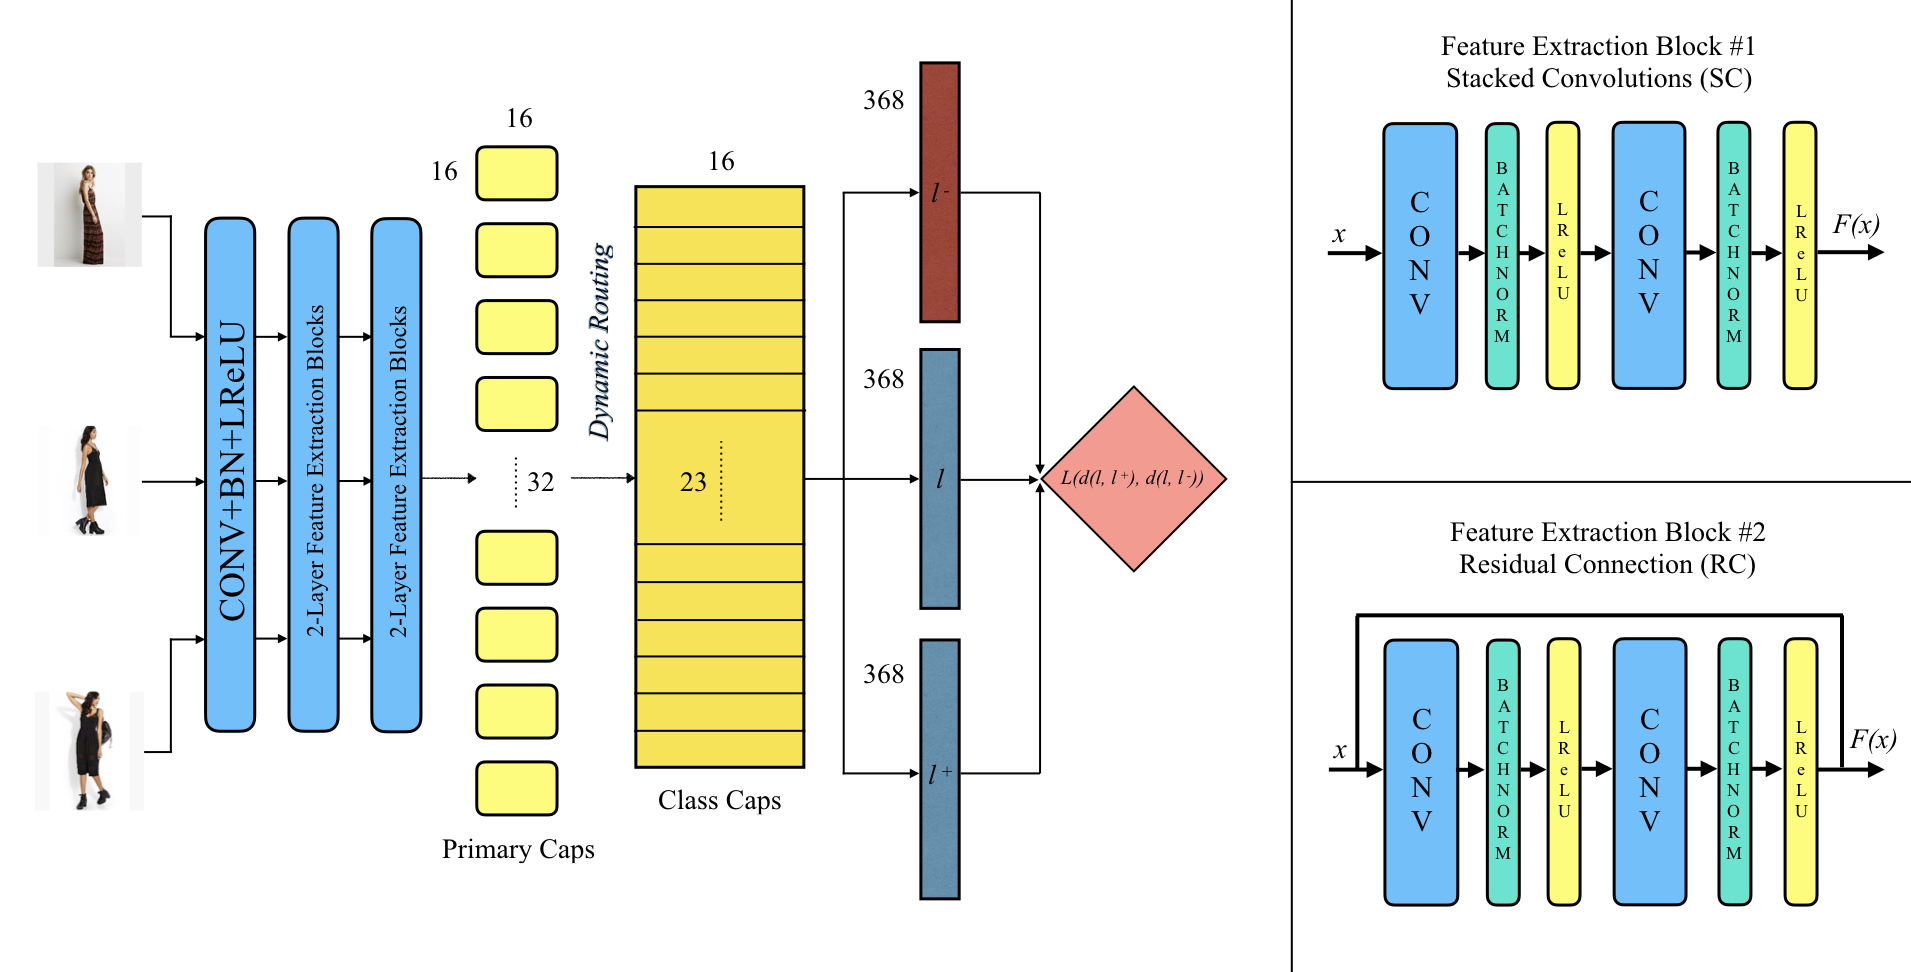

## New changes to the original code

1. Added "Download Dataset" section
2. Added "Install Packages" section 
2. In "Config" this configs changed: **epochs = 1**, **multi_gpu=None**, **model_type='rc'**
3. In "Config" This line Changed: "args = parser.parse_args()" changed to "args, unknown = parser.parse_known_args()"
3.  In "Main/Train" this line changed:
"if i % 5 == 0: test(model=eval_model, args=args)" changed to "i % 1 == 0: test(model=eval_model, args=args)"
6. Added "eval_partioner_by_group(group)" and you can choose "group" in config.by default group='ALL'.you can ghange it to 'WOMEN' or 'MEN' and then edit the 'num_class' value.


# Download Dataset 

In [ ]:
def download_dataset():
  !pip install gdown
  !gdown --id 0B7EVK8r0v71pS2YxRE1QTFZzekU
  !unzip img.zip
  !mkdir data
  !mv img data
  !rm img.zip

  !gdown --id 0B7EVK8r0v71pYVBqLXpRVjhHeWM
  !mkdir data/Eval
  !mv list_eval_partition.txt data/Eval

In [ ]:
import os
if not os.path.exists('./data'):
    download_dataset()

#Install Packages

In [ ]:
!pip install numpy==1.16.4
!pip install h5py==2.8.0
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14
!pip install Keras==2.2.4
!pip install Keras-Applications==1.0.8
!pip install Keras-Preprocessing==1.1.0
!pip install colorama==0.4.1
!pip install tqdm==4.32.1

In [ ]:
import os 
import time 
import numpy as np 
from tqdm import tqdm 
from colorama import Fore 
from keras import optimizers, callbacks 
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend as K 
import argparse 
from keras import models, layers 
from keras.utils import multi_gpu_model 
from keras import initializers, activations 
import tensorflow as tf 
from keras.metrics import kullback_leibler_divergence 
from keras.preprocessing import image 
from random import shuffle 
import numpy.random as rng 
import re 
import shutil 
import csv 

# Config

In [ ]:
def get_arguments():
    # Define all hyper-parameters
    parser = argparse.ArgumentParser(description="In-shop Image Retrieval with Capsule Networks")

    # INPUT & OUTPUT
    parser.add_argument('--filepath', default='./data/img/BOTH', type=str)
    parser.add_argument('--save_dir', default='./results_sq_euc')

    # MODEL ARCHITECTURE
    parser.add_argument('--group', default="ALL", type=str) # ALL,WOMEN,MEN ,you must edit num_class too.
    parser.add_argument('--num_class', default=23, type=int) # ALL=23,WOMEN=14,MEN=9

    parser.add_argument('--input_size', default=256, type=int)
    parser.add_argument('-k', '--top_k', default=20, type=int)  # unused
    parser.add_argument('-mt', '--metric_type', default="euclidean", type=str)
    parser.add_argument('-m', '--model_type', default="rc", type=str)
    parser.add_argument('-c', '--category', default=-1, type=int)
    parser.add_argument('--conv_filters', default=256, type=int)
    parser.add_argument('--conv_kernel_size', default=9, type=int)
    parser.add_argument('--dim_capsule', default=16, type=int)
    parser.add_argument('--epochs', default=1, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--lr', default=0.001, type=float,
                        help="Initial learning rate")
    parser.add_argument('--lr_decay', default=0.995, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=9.8304, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('--patience', default=20, type=int,
                        help="The number of patience epochs for early stopping")  # unused
    parser.add_argument('-r', '--routings', default=3, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing data set")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    parser.add_argument('--multi_gpu', default=None, type=int,
                        help="The number of gpu available as >1, if =1, then leave default as None")
    parser.add_argument('--initial_epoch', default=0, type=int,
                        help="The initial epoch for beginning of the training")
    parser.add_argument('--recon', default=False, type=bool,
                        help="Saving the reconstructed images during testing")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--verbose', default=1, type=int,
                        help="Verbose or not")

    # DATA AUGMENTATION
    parser.add_argument('--shift_fraction', default=0.2, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
    parser.add_argument('--hor_flip', default=True, type=bool,
                        help="Flipping the images randomly on horizontal line.")
    parser.add_argument('--whitening', default=False, type=bool,
                        help="Applies ZCA Whitening randomly.")
    parser.add_argument('--rotation_range', default=30, type=int,
                        help="The range of rotation degree for the images.")
    parser.add_argument('--brightness_range', default=[1.5, 0.5], type=list,
                        help="The range of brightness degree for the images.")
    parser.add_argument('--shear_range', default=0.1, type=float,
                        help="Shear angle in counter-clockwise direction in degrees.")
    parser.add_argument('--zoom_range', default=0.1, type=float,
                        help="Range for random zoom for the images.")

    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    print(args)
    return args


# Annotation_parser

In [ ]:
splitter = re.compile("\s+")
base_path = "./data/"

In [ ]:
def eval_partioner():
        # Read the relevant annotation file and preprocess it
        # Assumed that the annotation files are under '<project folder>/data/anno' path
        with open(os.path.join(base_path, 'Eval/list_eval_partition.txt'), 'r') as eval_partition_file:
            list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
            list_eval_partition = [splitter.split(line) for line in list_eval_partition]
            print(list_eval_partition)
            list_all = [(v[0], v[0].split('/')[2], v[1], v[2], v[0].split('/')[1]) for v in list_eval_partition]
            print(list_all)

        new_path = os.path.join(os.path.join(base_path, "img"), "BOTH")

        if not os.path.exists(new_path):
            os.mkdir(new_path)

        # Put each image into the relevant folder in train/test/validation folder
        for element in list_all:
            if not os.path.exists(os.path.join(new_path, element[3])):
                os.mkdir(os.path.join(new_path, element[3]))
            if not os.path.exists(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1])):
                os.mkdir(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1]))
            if not os.path.exists(os.path.join(os.path.join(os.path.join(os.path.join(new_path, element[3]),
                                                                         element[4] + "_" + element[1])),
                                  element[2])):
                os.mkdir(os.path.join(os.path.join(os.path.join(os.path.join(new_path, element[3]),
                                                                element[4]+"_"+element[1])),
                         element[2]))
            shutil.move(os.path.join(base_path, element[0]),
                        os.path.join(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1]),
                                     element[2]))
            




In [ ]:
def eval_partioner_by_group(group):
        # Read the relevant annotation file and preprocess it
        # Assumed that the annotation files are under '<project folder>/data/anno' path
        with open(os.path.join(base_path, 'Eval/list_eval_partition.txt'), 'r') as eval_partition_file:
            list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
            list_eval_partition = [splitter.split(line) for line in list_eval_partition]
            print(list_eval_partition)
            list_all = [(v[0], v[0].split('/')[2], v[1], v[2], v[0].split('/')[1]) for v in list_eval_partition]
            print(list_all)

        new_path = os.path.join(os.path.join(base_path, "img"), "BOTH")

        if not os.path.exists(new_path):
            os.mkdir(new_path)

        # Put each image into the relevant folder in train/test/validation folder
        for element in list_all:
          if(element[4]==group):
            if not os.path.exists(os.path.join(new_path, element[3])):
                os.mkdir(os.path.join(new_path, element[3]))
            if not os.path.exists(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1])):
                os.mkdir(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1]))
            if not os.path.exists(os.path.join(os.path.join(os.path.join(os.path.join(new_path, element[3]),
                                                                         element[4] + "_" + element[1])),
                                  element[2])):
                os.mkdir(os.path.join(os.path.join(os.path.join(os.path.join(new_path, element[3]),
                                                                element[4]+"_"+element[1])),
                         element[2]))
            shutil.move(os.path.join(base_path, element[0]),
                        os.path.join(os.path.join(os.path.join(new_path, element[3]), element[4]+"_"+element[1]),
                                     element[2]))
            




In [ ]:
def extract_neg_hard_pairs():
    path = os.path.join(os.path.join(os.path.join(base_path, "img"), "BOTH"), "train")

    datagen_anchor = image.ImageDataGenerator(rescale=1 / 255.)
    datagen_negative = image.ImageDataGenerator(rescale=1 / 255.)

    iterator_anchor = image.DirectoryIterator(directory=path, image_data_generator=datagen_anchor,
                                              batch_size=1, target_size=(64, 64))
    iterator_negative = image.DirectoryIterator(directory=path, image_data_generator=datagen_negative,
                                                batch_size=1, target_size=(64, 64))

    def euclidean_dist(a, n):
        return np.sum(np.square((a - n))) / 64

    for i in tqdm(range(len(iterator_anchor)), ncols=100, desc="Training",
                  bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        info_anchor = iterator_anchor.filenames[i].split("/")
        cls_idx_anchor = info_anchor[0]
        item_idx_anchor = info_anchor[1]
        item_name_anchor = info_anchor[2]

        img_anchor, y_anchor = next(iterator_anchor)
        closest_dist = 1e9
        closest_cls_idx = -1
        closest_item_idx = -1
        closest_item_name = ""
        dist = 0
        for j in range(len(iterator_negative)):
            info_negative = iterator_negative.filenames[j].split("/")
            cls_idx_negative = info_negative[0]
            item_idx_negative = info_negative[1]
            item_name_negative = info_negative[2]

            img_negative, y_negative = next(iterator_negative)
            # dist = euclidean_dist(img_anchor, img_negative)

            if cls_idx_anchor != cls_idx_negative and closest_dist > dist:
                closest_dist = dist
                closest_cls_idx = cls_idx_negative
                closest_item_idx = item_idx_negative
                closest_item_name = item_name_negative

        pair_dict = {"c_idx_anc": cls_idx_anchor,
                     "c_idx_neg": closest_cls_idx,
                     "i_idx_anc": item_idx_anchor,
                     "i_idx_neg": closest_item_idx,
                     "i_name_anc": item_name_anchor,
                     "i_name_neg": closest_item_name,
                     "distance": closest_dist}

        print(pair_dict)

        with open('./data/Anno/hard_neg_pairs.csv', 'w') as output_file:
            writer = csv.writer(output_file)
            for key, value in pair_dict.items():
                writer.writerow([key, value])

In [ ]:
if not os.path.exists('./data/img/BOTH'):
  args=get_arguments()
  if(args.group!="ALL"):
    eval_partioner_by_group(args.group)
  else:
     eval_partioner()    
# extract_neg_hard_pairs()

# TripletDirectoryIterator

In [ ]:
splitter = re.compile("\s+")


class TripletDirectoryIterator(image.DirectoryIterator):
    def __init__(self, directory, image_data_generator,
                 bounding_boxes: dict = None, landmark_info: dict = None, attr_info: dict = None,
                 num_landmarks=26, num_attrs=463,
                 target_size=(256, 256), color_mode: str = 'rgb',
                 classes=None, class_mode: str = 'categorical',
                 batch_size: int = 32, shuffle: bool = True, seed=None, data_format=None,
                 follow_links: bool = False):
        super().__init__(directory, image_data_generator, target_size, color_mode, classes, class_mode, batch_size,
                         shuffle, seed, data_format, follow_links)
        self.bounding_boxes = bounding_boxes
        self.landmark_info = landmark_info
        self.attr_info = attr_info
        self.num_landmarks = num_landmarks
        self.num_attrs = num_attrs
        self.num_bbox = 4

    def next(self):
        """
        # Returns
            The next batch.
        """

        locations = np.zeros((self.batch_size,) + (self.num_bbox,), dtype=K.floatx())
        landmarks = np.zeros((self.batch_size,) + (self.num_landmarks,), dtype=K.floatx())
        attributes = np.zeros((self.batch_size,) + (self.num_attrs,), dtype=K.floatx())

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((self.batch_size, self.target_size[0], self.target_size[1], 3)) for _ in range(3)]
        batch_y = [np.zeros((self.batch_size, self.num_classes)) for _ in range(3)]

        for i in range(self.batch_size):
            # Pick anchor image
            # print("Anchor image")
            idx_1 = rng.randint(0, self.samples)
            anchor_item_idx = str(self.filenames[idx_1]).split("/")[-2]
            pairs[0][i, :, :, :] = self.get_image(idx_1)
            batch_y[0][i, self.classes[idx_1]] = 1
            # print(anchor_item_idx)

            # pick positive and negative samples to anchor image.
            # print("Positive image")
            idx_2 = rng.randint(0, self.samples)
            positive_item_idx = str(self.filenames[idx_2]).split("/")[-2]
            while positive_item_idx != anchor_item_idx:
                idx_2 = rng.randint(0, self.samples)
                positive_item_idx = str(self.filenames[idx_2]).split("/")[-2]

            # print(positive_item_idx)
            pairs[1][i, :, :, :] = self.get_image(idx_2)
            batch_y[1][i, self.classes[idx_2]] = 1

            # print("Negative image")
            idx_3 = rng.randint(0, self.samples)
            negative_item_idx = str(self.filenames[idx_3]).split("/")[-2]
            while negative_item_idx == anchor_item_idx:
                idx_3 = rng.randint(0, self.samples)
                negative_item_idx = str(self.filenames[idx_3]).split("/")[-2]

            # print(negative_item_idx)
            pairs[2][i, :, :, :] = self.get_image(idx_3)
            batch_y[2][i, self.classes[idx_3]] = 1

            if self.bounding_boxes is not None:
                locations[i] = (self.get_bbox(self.filenames[idx_1]),
                                self.get_bbox(self.filenames[idx_2]),
                                self.get_bbox(self.filenames[idx_3]))

            if self.landmark_info is not None:
                landmarks[i] = (self.get_landmark_info(self.filenames[idx_1]),
                                self.get_landmark_info(self.filenames[idx_2]),
                                self.get_landmark_info(self.filenames[idx_3]))

            if self.attr_info is not None:
                attr_info_lst_1 = self.attr_info[self.filenames[idx_1]]
                attr_info_lst_2 = self.attr_info[self.filenames[idx_2]]
                attr_info_lst_3 = self.attr_info[self.filenames[idx_3]]
                attributes[i] = (np.asarray(attr_info_lst_1), np.asarray(attr_info_lst_2), np.asarray(attr_info_lst_3))

        if self.shuffle:
            self.shuffle_batches(batch_y, pairs)

        pairs = np.asarray(pairs)

        # y = [batch_y, locations, landmarks, attributes]
        # statements = [True, self.bounding_boxes is not None,
        #               self.landmark_info is not None, self.attr_info is not None]
        #
        # y = np.asarray([y_ for y_, s in zip(y, statements) if s]).reshape((self.batch_size,))

        return pairs, batch_y

    @staticmethod
    def shuffle_batches(batch_y, pairs):
        anchor_img = pairs[0]
        anchor_y = batch_y[0]
        positive_img = pairs[1]
        positive_y = batch_y[1]
        negative_img = pairs[2]
        negative_y = batch_y[2]
        tmp = list(zip(anchor_img, positive_img, negative_img, anchor_y, positive_y, negative_y))
        shuffle(tmp)
        anchor_img, positive_img, negative_img, anchor_y, positive_y, negative_y = zip(*tmp)
        pairs[0] = np.array(anchor_img)
        pairs[1] = np.array(positive_img)
        pairs[2] = np.array(negative_img)
        batch_y[0] = np.array(anchor_y)
        batch_y[1] = np.array(positive_y)
        batch_y[2] = np.array(negative_y)

    def get_image(self, idx):
        fname = self.filenames[idx]
        # print("Category: " + str(self.classes[idx_2]) + ", Filename: " + str(fname_2) + "\n")
        img = image.load_img(os.path.join(self.directory, fname),
                             grayscale=self.color_mode == 'grayscale',
                             target_size=self.target_size)
        img = image.img_to_array(img, data_format=self.data_format)
        img = self.image_data_generator.random_transform(img)
        img = self.image_data_generator.standardize(img)
        return img

    def get_bbox(self, fname):
        bbox = self.bounding_boxes[fname]
        return np.asarray([bbox['origin']['x'], bbox['origin']['y'], bbox['width'], bbox['height']], dtype=K.floatx())

    def get_landmark_info(self, fname):
        landmark_info = self.landmark_info[fname]
        return np.asarray([landmark_info["clothes_type"], landmark_info["variation_type"],
                           landmark_info['1']['visibility'], landmark_info['1']['x'],
                           landmark_info['1']['y'],
                           landmark_info['2']['visibility'], landmark_info['2']['x'],
                           landmark_info['2']['y'],
                           landmark_info['3']['visibility'], landmark_info['3']['x'],
                           landmark_info['3']['y'],
                           landmark_info['4']['visibility'], landmark_info['4']['x'],
                           landmark_info['4']['y'],
                           landmark_info['5']['visibility'], landmark_info['5']['x'],
                           landmark_info['5']['y'],
                           landmark_info['6']['visibility'], landmark_info['6']['x'],
                           landmark_info['6']['y'],
                           landmark_info['7']['visibility'], landmark_info['7']['x'],
                           landmark_info['7']['y'],
                           landmark_info['8']['visibility'], landmark_info['8']['x'],
                           landmark_info['8']['y']], dtype=K.floatx())


# Utils

In [ ]:
args = get_arguments()


def triplet_eucliden_loss(y_true, y_pred):
    enc_size = int(K.get_variable_shape(y_pred)[1]/3)
    anchor_encoding = y_pred[:, :enc_size]
    positive_encoding = y_pred[:, enc_size:2 * enc_size]
    negative_encoding = y_pred[:, 2 * enc_size:]
    margin = K.constant(2.0)

    def euclidean_dist(a, e):
        return K.sum(K.square(a - e), axis=-1)  # squared euclidean distance
        # return K.sqrt(K.sum(K.square(a - e), axis=-1))  # original euclidean distance

    pos_dist = euclidean_dist(anchor_encoding, positive_encoding)
    neg_dist = euclidean_dist(anchor_encoding, negative_encoding)
    basic_loss = pos_dist - neg_dist + margin

    return K.mean(K.maximum(basic_loss, 0.0))


def triplet_cosine_loss(y_true, y_pred):
    enc_size = int(K.get_variable_shape(y_pred)[1] / 3)
    anchor_encoding = y_pred[:, :enc_size]
    positive_encoding = y_pred[:, enc_size:2 * enc_size]
    negative_encoding = y_pred[:, 2 * enc_size:]

    def cosine_similarity(a, e):
        return K.batch_dot(a, e, axes=-1)  # simple dot product since vectors are l2_normed and pdf

    pos_sim = cosine_similarity(anchor_encoding, positive_encoding)
    neg_sim = cosine_similarity(anchor_encoding, negative_encoding)

    return K.mean(K.sum(K.log(1 + K.exp(-(pos_sim - neg_sim))), axis=-1))


def margin_loss(y_true, y_pred):
    m_plus = 0.9
    m_minus = 1 - m_plus
    lamb = 0.5

    loss = y_true * K.square(K.relu(m_plus - y_pred)) + \
        lamb * (1 - y_true) * K.square(K.relu(y_pred - m_minus))

    return K.sum(loss, axis=-1)


def kl_divergence(y_true, y_pred):
    alpha = 0.9
    beta = 0.1
    enc_size = int(K.get_variable_shape(y_pred)[1] / 3)
    anchor_encoding = y_pred[:, :enc_size]
    positive_encoding = y_pred[:, enc_size:2 * enc_size]
    negative_encoding = y_pred[:, 2 * enc_size:]

    return alpha * kullback_leibler_divergence(anchor_encoding, positive_encoding) + \
        beta * kullback_leibler_divergence(anchor_encoding, (K.reverse(negative_encoding, axes=-1)))


def squash(activations, axis=-1):
    scale = K.sum(K.square(activations), axis, keepdims=True) / \
            (1 + K.sum(K.square(activations), axis, keepdims=True)) / \
            K.sqrt(K.sum(K.square(activations), axis, keepdims=True) + K.epsilon())
    return scale * activations


def decay_lr(lr, rate):
    return lr * rate


def custom_generator(it):
    while True:
        pairs_batch, y_batch = it.next()
        yield ([pairs_batch[0], pairs_batch[1], pairs_batch[2], y_batch[0]],
               [y_batch[0], y_batch[0], y_batch[1], y_batch[2]])


def get_iterator(file_path, input_size=256, batch_size=32,
                 shift_fraction=0., h_flip=False, zca_whit=False, rot_range=0.,
                 bright_range=0., shear_range=0., zoom_range=0.):
    data_gen = image.ImageDataGenerator(width_shift_range=shift_fraction,
                                        height_shift_range=shift_fraction,
                                        horizontal_flip=h_flip,
                                        zca_whitening=zca_whit,
                                        rotation_range=rot_range,
                                        brightness_range=bright_range,
                                        shear_range=shear_range,
                                        zoom_range=zoom_range,
                                        rescale=1./255)
    t_iterator = TripletDirectoryIterator(directory=file_path, image_data_generator=data_gen,
                                          batch_size=batch_size, target_size=(input_size, input_size))

    return t_iterator


# Layers

In [ ]:
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        return super(Length, self).get_config()


In [ ]:
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            mask = K.one_hot(indices=K.argmax(K.sqrt(K.sum(K.square(inputs), -1)), 1),
                             num_classes=K.sqrt(K.sum(K.square(inputs), -1)).get_shape().as_list()[1])

        return K.batch_flatten(inputs * K.expand_dims(mask, -1))

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        return super(Mask, self).get_config()


In [ ]:
class FashionCaps(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 share_weights=True, activation='squash', kernel_initializer='glorot_uniform', **kwargs):
        super(FashionCaps, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        self.kernel_initializer = initializers.get(kernel_initializer)
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        assert len(input_shape) >= 3
        input_num_capsule = input_shape[1]
        input_dim_capsule = input_shape[2]
        if self.share_weights:
            self.kernel = self.add_weight(name='capsule_kernel',
                                          shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                          initializer=self.kernel_initializer,
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name='capsule_kernel',
                                          shape=(input_num_capsule, input_dim_capsule,
                                                 self.num_capsule * self.dim_capsule),
                                          initializer=self.kernel_initializer,
                                          trainable=True)

    def call(self, inputs, training=None):
        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, dim=1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])

        # # # AVARAJ ROUT # # #
        # norm_hat_inputs = tf.norm(hat_inputs, axis=-1)
        # weighted_hat_inputs = hat_inputs * tf.expand_dims(norm_hat_inputs, axis=-1)
        # o = K.sum(weighted_hat_inputs, axis=2) / self.dim_capsule
        # o = self.activation(o)

        return o

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {'num_capsule': self.num_capsule,
                  'dim_capsule': self.dim_capsule,
                  'routings': self.routings}
        base_config = super(FashionCaps, self).get_config()
        new_config = list(base_config.items()) + list(config.items())
        return dict(new_config)


# Blocks

In [ ]:
def conv_bn_block(inputs, filters, k_size, stride, padding, name):
    out = layers.Conv2D(filters=filters, kernel_size=k_size, strides=stride, padding=padding, name=name)(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    return layers.SpatialDropout2D(rate=0.3)(out)


def transpose_conv_bn_block(inputs, filters, k_size, stride, padding, name):
    out = layers.Conv2DTranspose(filters=filters, kernel_size=k_size, strides=stride, padding=padding,
                                 name=name)(inputs)
    out = layers.BatchNormalization(axis=-1)(out)
    out = layers.ReLU()(out)
    return layers.SpatialDropout2D(rate=0.3)(out)


def residual_block(y, nb_channels, _strides=(2, 2), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y


def inception_block(y, nb_channels, k_size=3, name=None):
    br_0 = layers.Conv2D(nb_channels, k_size, padding="same", name=name + "_br_0")(y)
    br_0 = layers.BatchNormalization()(br_0)
    br_1 = layers.Conv2D(nb_channels, k_size, padding="same", name=name + "_br_1_0")(y)
    br_1 = layers.Conv2D(2 * nb_channels, k_size, padding="same", name=name + "_br_1_1")(br_1)
    br_1 = layers.BatchNormalization()(br_1)
    br_2 = layers.Conv2D(nb_channels, k_size, padding="same", name=name + "_br_2_0")(y)
    br_2 = layers.Conv2D(int(3 * nb_channels / 2), k_size, padding="same", name=name + "_br_2_1")(br_2)
    br_2 = layers.Conv2D(2 * nb_channels, k_size, padding="same", name=name + "_br_2_2")(br_2)
    br_2 = layers.BatchNormalization()(br_2)
    mix = layers.concatenate([br_0, br_1, br_2], axis=-1, name=name+"_concat")
    mix = layers.Conv2D(2 * nb_channels, kernel_size=1, strides=2, name=name+"_1_by_1")(mix)
    return layers.LeakyReLU()(mix)


def primary_capsule(inputs, dim_capsule, name, args, n_channels=32, kernel_size=7, strides=2, padding="same"):
    # inputs = inception_block(inputs, nb_channels=int(dim_capsule*n_channels/2), name=name+"_primary_conv")
    if args.model_type == "rc":
        inputs = residual_block(inputs, nb_channels=dim_capsule*n_channels, _project_shortcut=True)
    else:
        inputs = layers.Conv2D(filters=dim_capsule * n_channels, kernel_size=kernel_size, strides=strides,
                               padding=padding,
                               name=name + '_conv')(inputs)
    inputs = layers.Reshape(target_shape=[-1, dim_capsule], name=name+'_reshape')(inputs)
    return layers.Lambda(squash, name=name+'_squash')(inputs)


def capsule_model(inputs, args):
    out = conv_bn_block(inputs, filters=64, k_size=7, stride=2, padding="same", name="conv_block_1")

    # out = inception_block(out, nb_channels=64, name="inception0")
    # out = layers.SpatialDropout2D(rate=0.3)(out)
    # out = inception_block(out, nb_channels=128, name="inception1")
    # out = layers.SpatialDropout2D(rate=0.3)(out)

    if args.model_type == "rc":
        out = residual_block(out, nb_channels=128, _project_shortcut=True)
        out = layers.SpatialDropout2D(rate=0.3)(out)
        out = residual_block(out, nb_channels=256, _project_shortcut=True)
        out = layers.SpatialDropout2D(rate=0.3)(out)
    else:
        out = conv_bn_block(out, filters=128, k_size=7, stride=2, padding="same", name="conv_block_2")
        out = conv_bn_block(out, filters=64, k_size=7, stride=2, padding="same", name="conv_block_3")

    out = primary_capsule(out, dim_capsule=16, name="primarycaps", args=args)
    out = FashionCaps(num_capsule=args.num_class, dim_capsule=args.dim_capsule, routings=3, name="fashioncaps")(out)
    return out


def decoder_model(inputs):
    out = layers.Dense(8*8*256, activation='relu')(inputs)
    out = layers.Reshape((8, 8, 256))(out)
    out = transpose_conv_bn_block(out, filters=128, k_size=9, stride=1, padding='same', name="t_conv_block_1")
    out = transpose_conv_bn_block(out, filters=64, k_size=7, stride=2, padding='same', name="t_conv_block_2")
    out = transpose_conv_bn_block(out, filters=32, k_size=7, stride=2, padding='same', name="t_conv_block_3")
    out = transpose_conv_bn_block(out, filters=16, k_size=5, stride=2, padding='same', name="t_conv_block_4")
    out = transpose_conv_bn_block(out, filters=16, k_size=5, stride=2, padding='same', name="t_conv_block_5")
    return layers.Conv2DTranspose(filters=3, kernel_size=5, strides=2, padding='same', activation='sigmoid',
                                  name="decoder_out")(out)


# Models

In [ ]:
class MultiGPUNet(models.Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        '''
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(MultiGPUNet, self).__getattribute__(attrname)


In [ ]:
def FashionTripletCapsNet(input_shape, args):
    x = layers.Input(shape=input_shape)

    caps_model = models.Model(x, capsule_model(x, args))
    caps_model.summary()

    x1 = layers.Input(shape=input_shape)
    x2 = layers.Input(shape=input_shape)
    x3 = layers.Input(shape=input_shape)

    anchor_encoding = caps_model(x1)
    positive_encoding = caps_model(x2)
    negative_encoding = caps_model(x3)

    # shape: (None, NUM_CLASS, DIM_CAPSULE)

    l2_norm = layers.Lambda(lambda enc: K.l2_normalize(enc, axis=-1) + K.epsilon())
    l2_anchor_encoding = l2_norm(anchor_encoding)
    l2_positive_encoding = l2_norm(positive_encoding)
    l2_negative_encoding = l2_norm(negative_encoding)

    y1 = layers.Input(shape=(args.num_class,))

    masked_anchor_encoding = Mask(name="anchor_mask")([l2_anchor_encoding, y1])
    masked_positive_encoding = Mask(name="positive_mask")([l2_positive_encoding, y1])
    masked_negative_encoding = Mask(name="negative_mask")([l2_negative_encoding, y1])

    # shape: (None, NUM_CLASS*DIM_CAPSULE)

    out = layers.Concatenate()([masked_anchor_encoding, masked_positive_encoding, masked_negative_encoding])

    cls_out_anchor = Length(name="anchor_class")(anchor_encoding)
    cls_out_positive = Length(name="positive_class")(positive_encoding)
    cls_out_negative = Length(name="negative_class")(negative_encoding)

    model = models.Model(inputs=[x1, x2, x3, y1],
                         outputs=[out, cls_out_anchor, cls_out_positive, cls_out_negative])
    eval_model = models.Model(inputs=[x1, y1], outputs=masked_anchor_encoding)

    return model, eval_model


# Main


In [ ]:
def train(model, eval_model, args):
    # Compile the model
    if args.metric_type == "euclidean":
        model.compile(optimizer=optimizers.Adam(lr=args.lr),
                      loss=[triplet_eucliden_loss, "mse", "mse", "mse"],
                      loss_weights=[1., 0., 0., 0.])
    elif args.metric_type == "cosine":
        model.compile(optimizer=optimizers.Adam(lr=args.lr),
                      loss=[triplet_cosine_loss, margin_loss,
                            margin_loss, margin_loss],
                      loss_weights=[1., 0.2, 0.2, 0.2])
    else:
        raise Exception("Wrong metric type. Available: ['euclidean', 'cosine']")

    if not os.path.isdir(os.path.join(args.save_dir, "tensorboard-logs")):
        os.mkdir(os.path.join(args.save_dir, "tensorboard-logs"))

    tensorboard = callbacks.TensorBoard(log_dir=os.path.join(args.save_dir, "tensorboard-logs"),
                                        histogram_freq=0, batch_size=args.batch_size,
                                        write_graph=True, write_grads=True)
    tensorboard.set_model(model)

    lr_scheduler = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))
    lr_scheduler.set_model(model)

    train_iterator = get_iterator(os.path.join(args.filepath, "train"), args.input_size, args.batch_size,
                                  args.shift_fraction, args.hor_flip, args.whitening, args.rotation_range,
                                  args.brightness_range, args.shear_range, args.zoom_range)
    train_generator = custom_generator(train_iterator)

    losses = list()
    for i in range(args.initial_epoch, args.epochs):
        total_loss, total_triplet_loss = 0, 0
        total_anchor_xentr, total_positive_xentr, total_negative_xentr = 0, 0, 0

        print("Epoch (" + str(i+1) + "/" + str(args.epochs) + "):")
        t_start = time.time()
        lr_scheduler.on_epoch_begin(i)
        if i > 0:
            print("\nLearning rate is reduced to {:.8f}.".format(K.get_value(model.optimizer.lr)))

        for j in tqdm(range(len(train_iterator)), ncols=100, desc="Training",
                      bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            x, y = next(train_generator)

            loss, triplet_loss_, anchor_xentr, positive_xentr, negative_xentr = model.train_on_batch(x, y)
            total_loss += loss
            total_triplet_loss += triplet_loss_
            total_anchor_xentr += anchor_xentr
            total_positive_xentr += positive_xentr
            total_negative_xentr += negative_xentr

            if args.metric_type == "euclidean":
                print("\tTotal Loss: {:.4f}"
                      "\tTriplet Loss: {:.4f}".format(total_loss / (j + 1),
                                                      total_triplet_loss / (j + 1)),  "\r", end="")
            elif args.metric_type == "cosine":
                print("\tTotal Loss: {:.4f}"
                      "\tTriplet: {:.4f}"
                      "\tA X-Ent: {:.4f}"
                      "\tP X-Ent: {:.4f}"
                      "\tN X-Ent: {:.4f}".format(total_loss / (j + 1),
                                                 total_triplet_loss / (j + 1),
                                                 total_anchor_xentr / (j + 1),
                                                 total_positive_xentr / (j + 1),
                                                 total_negative_xentr / (j + 1)), "\r", end="")
            else:
                Exception("Wrong metric type. Available: ['euclidean', 'cosine']")

        print("\nEpoch ({}/{}) completed in {:5.6f} secs.".format(i+1, args.epochs, time.time()-t_start))

        if i % 1 == 0:
            print("\nEvaluating the model...")
            test(model=eval_model, args=args)

        # On epoch end loss and improved or not
        on_epoch_end_loss = total_loss/len(train_iterator)
        on_epoch_end_triplet = total_triplet_loss/len(train_iterator)
        on_epoch_end_a_xentr = total_anchor_xentr / len(train_iterator)
        on_epoch_end_p_xentr = total_positive_xentr / len(train_iterator)
        on_epoch_end_n_xentr = total_negative_xentr / len(train_iterator)
        print("On epoch end loss: {:.6f}".format(on_epoch_end_loss))
        if len(losses) > 0:
            if np.min(losses) > on_epoch_end_loss:
                print("\nSaving weights to {}".format(os.path.join(args.save_dir, "weights-" + str(i+1) + ".h5")))
                # if os.path.isfile(os.path.join(args.save_dir, "weights-" + str(np.argmin(losses)) + ".h5")):
                #     os.remove(os.path.join(args.save_dir, "weights-" + str(np.argmin(losses)) + ".h5"))
                model.save_weights(os.path.join(args.save_dir, "weights-" + str(i+1) + ".h5"))
            else:
                print("\nLoss value {:.6f} not improved from ({:.6f})".format(on_epoch_end_loss, np.min(losses)))
        else:
            print("\nSaving weights to {}".format(os.path.join(args.save_dir, "weights-" + str(i+1) + ".h5")))
            model.save_weights(os.path.join(args.save_dir, "weights-" + str(i+1) + ".h5"))

        losses.append(on_epoch_end_loss)

        # LR scheduling
        lr_scheduler.on_epoch_end(i)

        # Tensorboard
        tensorboard.on_epoch_end(i, {"Total Loss": on_epoch_end_loss,
                                     "Triplet Loss": on_epoch_end_triplet,
                                     "Anchor X-Entropy Loss": on_epoch_end_a_xentr,
                                     "Positive X-Entropy Loss": on_epoch_end_p_xentr,
                                     "Negative X-Entropy Loss": on_epoch_end_n_xentr,
                                     "Learning rate": K.get_value(model.optimizer.lr)})

    tensorboard.on_train_end(None)

    # Model saving
    model_path = 't_model.h5'
    model.save(os.path.join(args.save_dir, model_path))
    print("The model file saved to \"{}\"".format(os.path.join(args.save_dir, model_path)))



In [ ]:
def test(model, args):
    query_dict = extract_embeddings(model, args)
    gallery_dict = extract_embeddings(model, args, subset="gallery")

    results = list()
    print("Finding k closest images of gallery set to the query image...")
    t_start = time.time()
    for i in tqdm(range(len(query_dict["out"])), ncols=100, desc="Distance Calc",
                  bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        q_result = list()
        # if np.argmax(query_dict["cls"][i]) == args.category or args.category == -1:
        for j in range(len(gallery_dict["out"])):
            if args.metric_type == "euclidean":
                q_result.append({"is_same_cls": (np.argmax(query_dict["cls"][i]) == np.argmax(gallery_dict["cls"][j])),
                                 "is_same_item": (query_dict["fname"][i].split("/")[-2] ==
                                                  gallery_dict["fname"][j].split("/")[-2]),
                                 "distance": np.sum(np.square(query_dict["out"][i] - gallery_dict["out"][j]), axis=-1)})
            elif args.metric_type == "cosine":
                q_result.append({"is_same_cls": (np.argmax(query_dict["cls"][i]) == np.argmax(gallery_dict["cls"][j])),
                                 "is_same_item": (query_dict["fname"][i].split("/")[-2] ==
                                                  gallery_dict["fname"][j].split("/")[-2]),
                                 "distance": 1 - np.sum(query_dict["out"][i] * gallery_dict["out"][j], axis=-1)})
            else:
                raise Exception("Wrong metric type. Available: ['euclidean', 'cosine']")

        q_result = sorted(q_result, key=lambda r: r["distance"])

        results.append(q_result[:50])

    retr_acc_1 = eval_results(results, k=1)
    retr_acc_5 = eval_results(results, k=5)
    retr_acc_10 = eval_results(results, k=10)
    retr_acc_20 = eval_results(results, k=20)
    retr_acc_30 = eval_results(results, k=30)
    retr_acc_40 = eval_results(results, k=40)
    retr_acc_50 = eval_results(results)

    print("Testing is completed.\tTime Elapsed: {:5.2f}\n"
          "The retrieval accuracies:\n"
          "\tTop-1: {:2.2f}\n"
          "\tTop-5: {:2.2f}\n"
          "\tTop-10: {:2.2f}\n"
          "\tTop-20: {:2.2f}\n"
          "\tTop-30: {:2.2f}\n"
          "\tTop-40: {:2.2f}\n"
          "\tTop-50: {:2.2f}\n".format(time.time() - t_start, retr_acc_1, retr_acc_5,  retr_acc_10,
                                       retr_acc_20, retr_acc_30, retr_acc_40, retr_acc_50))


In [ ]:
    # TODO
    # # Reconstruct batch of images
    # if args.recon:
    #   x_test_batch, y_test_batch = get_iterator(args.filepath, subset="test").next()
    #   y_pred, x_recon = model.predict(x_test_batch)
    #
    #   # Save reconstructed and original images
    #   save_recons(x_recon, x_test_batch, y_pred, y_test_batch, args.save_dir)


In [ ]:
def extract_embeddings(model, args, subset="query"):
    print("Extracting features for each image in {} set...".format(subset))
    data_gen = ImageDataGenerator(rescale=1/255.)

    data_iterator = data_gen.flow_from_directory(directory=os.path.join(args.filepath, subset),
                                                 batch_size=args.batch_size,
                                                 shuffle=False)

    if args.category != -1:
        print(list(data_iterator.class_indices.keys())[list(data_iterator.class_indices.values()).index(args.category)])

    for i in tqdm(range(len(data_iterator)), ncols=100, desc=subset,
                  bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        xs, ys = next(data_iterator)

        y_pred = model.predict([xs, ys])

        if i > 0:
            embedings = np.vstack((embedings, y_pred))
            clss = np.vstack((clss, ys))
        else:
            embedings = np.array(y_pred)
            clss = np.array(ys)

    return {"out": embedings, "cls": clss, "fname": data_iterator.filenames}


In [ ]:
def eval_results(x, k=50):
    retrievals = list()
    for result in x:
        retrieved = False
        for r in result[:k]:
            if r["is_same_item"]:
                retrieved = True
                break
        retrievals.append(retrieved)

    return 100 * np.mean(retrievals)


In [ ]:
if __name__ == '__main__':
    K.clear_session()
    args = get_arguments()
    print(args)

    if not os.path.exists(args.save_dir):
        os.mkdir(args.save_dir)

    model, eval_model = FashionTripletCapsNet(input_shape=(args.input_size, args.input_size, 3), args=args)

    if args.weights is not None:
        model.load_weights(args.weights)
        eval_model.load_weights(args.weights)

    if args.multi_gpu and args.multi_gpu >= 2:
        p_model = MultiGPUNet(model, args.multi_gpu)
        p_eval_model = MultiGPUNet(eval_model, args.multi_gpu)

    if not args.testing:
        model.summary()
        if args.multi_gpu and args.multi_gpu >= 2:
            train(model=p_model, eval_model=p_eval_model, args=args)
            # implicitly sure that p_model defined
        else:
            train(model=model, eval_model=eval_model, args=args)
    else:
        eval_model.summary()
        if args.weights is None:
            print('Random initialization of weights.')
        test(model=p_eval_model, args=args)
